In [1]:
import pennylane as qml
import numpy as ap
import matplotlib.pyplot as plt
from jax import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

In [ ]:
dev1 = qml.device('lightning.qubit', wires=18)  # Create a quantum device

@qml.qnode(dev1)
def parallelized_swap_circuit(m, parameters, weights):
    # First register is range(0, m)
    first_register = list(range(m))
    
    # Second register is range(m, m+m+1) = range(m, 2*m+1)
    second_register = list(range(m, 2*m+1))
    
    # Third register is range(2*m+1, 3*m+2) = range(2*m+1, 3*m+2)
    third_register = list(range(2*m+1, 3*m+2))

    # Apply Hadamard gates to first register
    for i in first_register:
        qml.Hadamard(wires=i)

    # Apply strong entanglement layer to second and third registers
    qml.RZ(weights[0], wires=second_register[1])
    qml.RY(weights[1], wires=second_register[1])
    qml.RZ(weights[2], wires=second_register[1])
    qml.RZ(weights[0], wires=third_register[1])
    qml.RY(weights[1], wires=third_register[1])
    qml.RZ(weights[2], wires=third_register[1])
    qml.StronglyEntanglingLayers(weights=parameters, wires=second_register)
    qml.StronglyEntanglingLayers(weights=parameters, wires=third_register)

    # Apply CSWAP gates between registers
    for i in range(m):
        qml.CSWAP(wires=[i, second_register[i+1], third_register[i+1]])

    # Re-apply Hadamard gates to first register
    for i in first_register:
        qml.Hadamard(wires=i)

    # Return probabilities of the first register
    return qml.probs(wires=first_register)

In [ ]:
dev2 = qml.device('default.qubit', wires=18)  # Create a quantum device

@qml.qnode(dev2)
def density_circuit(m, parameters, weights):
    # First register is range(0, m+1)
    first_register = list(range(m+1))
    
    # Apply single-qubit rotations to the second qubit in the first register
    qml.RZ(weights[0], wires=first_register[1])
    qml.RY(weights[1], wires=first_register[1])
    qml.RZ(weights[2], wires=first_register[1])
    
    # Apply strongly entangling layers to the entire first register
    qml.StronglyEntanglingLayers(weights=parameters, wires=first_register)
    
    # Return the reduced density matrix of all qubits except the first one
    return qml.density_matrix(wires=first_register[1:])

In [4]:
def lower_bound(m,parameters,weights):
    probability,density_matrix=Parallized_swap_circuit(m,parameters,weights),density_circuit(m,parameters,weights)
    P=np.abs(np.trace(np.dot(density_matrix,density_matrix)))
    return(1/2**m+(1-1/2**m)*P-probability[0])

In [ ]:
# Weights array extracted from trained model parameters
weights = np.array([
    # First layer parameters
    [[ 0.3745401 ,  0.54911088,  1.24609457],
     [ 0.59865847, -0.31313117,  0.52250323],
     [ 0.0580836 ,  1.15064753,  0.28680257],
     [ 0.70807256,  0.49243661,  0.99629098]],

    # Second layer parameters  
    [[ 0.30961435, -0.27116542, -0.35740497],
     [ 0.60261284, -0.24929507,  0.97899436],
     [-0.12360435, -0.11431352,  0.10323433],
     [-0.35048157, -0.08254909, -0.03491928]],

    # Third layer parameters
    [[-0.05254858,  0.24620135,  0.29268646],
     [ 0.11295332,  0.1464061 ,  0.04645042],
     [ 0.60754485,  0.17052413,  0.06505159],
     [ 0.59997623,  1.36930842,  0.43382239]]
])

In [ ]:
# Define amplitude values for testing
a_values = [0.25, 0.5, 0.75, 1.0]

# Initialize a dictionary to store results for each amplitude
results = {a: [] for a in a_values}

# Monte Carlo simulation for each amplitude value
for a in a_values:
    # Perform 1000 trials for statistical significance
    for _ in range(1000):
        # Generate random parameters within [-a, a] range
        random_params = np.random.uniform(-a, a, size=3)
        
        # Calculate lower bound using our quantum circuit
        bound_value = lower_bound(
            m=3,                # Number of qubits in first register
            parameters=weights, # Pre-trained quantum circuit weights
            random_numbers=random_params  # Random parameters for this trial
        )
        
        # Store the result
        results[a].append(bound_value)

# Note: The lower_bound function should be defined elsewhere
# It presumably uses the quantum circuits we defined earlier
# (parallelized_swap_circuit and density_circuit)

In [ ]:
# Extract and store results for each amplitude value
pi_results1 = results[0.25]  # Results for a = 0.25
pi_results2 = results[0.5]    # Results for a = 0.5 (π/8 equivalent commented out)
pi_results3 = results[0.75]   # Results for a = 0.75
pi_results4 = results[1.0]    # Results for a = 1.0

# Print summary statistics for each amplitude
print("\nResults Summary:")
print(f"a = 0.25: {len(pi_results1)} samples, mean: {np.mean(pi_results1):.4f}")
print(f"a = 0.50: {len(pi_results2)} samples, mean: {np.mean(pi_results2):.4f}") 
print(f"a = 0.75: {len(pi_results3)} samples, mean: {np.mean(pi_results3):.4f}")
print(f"a = 1.00: {len(pi_results4)} samples, mean: {np.mean(pi_results4):.4f}")

# Note: The commented-out π-related values suggest this might be testing 
# quantum phase estimation or amplitude encoding applications

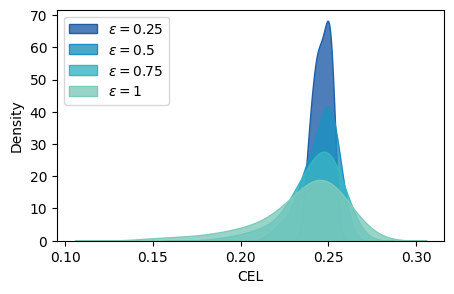

In [ ]:

from matplotlib.ticker import MaxNLocator

import seaborn as sns

plt.figure(figsize=(5, 3))


sns.kdeplot(np.array(pi_results1), label='$\epsilon=0.25$', fill=True,bw_adjust=2,color="#205EA8",alpha=0.8,lw=1)
sns.kdeplot(np.array(pi_results2), label='$\epsilon=0.5$', fill=True,bw_adjust=2,color="#1D91C2",alpha=0.8,lw=1)
sns.kdeplot(np.array(pi_results3), label='$\epsilon=0.75$', fill=True,bw_adjust=2,color="#38B6C4",alpha=0.8,lw=1)
sns.kdeplot(np.array(pi_results4), label='$\epsilon=1$', fill=True,bw_adjust=2,color="#7ECBBB",alpha=0.8,lw=1)
# sns.kdeplot(np.array(pi_results2), label='$\epsilon=0.25$', fill=True,bw_adjust=2,color="#D5EBF2",alpha=0.8,lw=2)
# sns.kdeplot(np.array(pi_results3), label='$\epsilon=0.5$', fill=True,bw_adjust=2,color="#96ABF2",alpha=0.6,lw=2)
# sns.kdeplot(np.array(pi_results4), label='$\epsilon=0.75$', fill=True,bw_adjust=2,color="#5B9BC8",alpha=0.4,lw=2)
# sns.kdeplot(np.array(pi_results1), label='$\epsilon=1$', fill=True,bw_adjust=2,color="#FFEAD8",alpha=0.2,lw=2)

plt.legend(loc='upper left')


plt.xlabel('CEL')
plt.ylabel('Density')

ax = plt.gca() 
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.savefig('disturb_plot.pdf', dpi=600, bbox_inches='tight')

plt.show()